# DA10 Preprocess
06/20/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA10'
subj_format = ['nlx']
subj_site = ['UCD']


## Load raw nlx data 


In [5]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [6]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [7]:
seeg_names = [x.lower() for x in seeg_names]
sEEG_mapping_dict = {f'{x}':'seeg' for x in seeg_names}

In [8]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [9]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}')

Unidentified data type in Photodiode


In [10]:
ch_name

['LTT1',
 'LHH5',
 'LHH4',
 'LAD1',
 'LHB9',
 'LHB8',
 'LTPO1',
 'LOF6',
 'LOF7',
 'LHB3',
 'LHB2',
 'LHH2',
 'LHH3',
 'LAD6',
 'LAD7',
 'LHH8',
 'LHH9',
 'LTPO7',
 'LTPO6',
 'LOF1',
 'LHB4',
 'LHB5',
 'LTT7',
 'LTT6',
 'Photodiode',
 'LTPO3',
 'LTPO2',
 'LAD8',
 'LAD9',
 'LOF5',
 'LOF4',
 'LHB1',
 'LAD2',
 'LAD3',
 'LHH6',
 'LHH7',
 'LTPO8',
 'LTT8',
 'LTT3',
 'LTT2',
 'LTT4',
 'LTT5',
 'LTPO4',
 'LTPO5',
 'LOF2',
 'LOF3',
 'LHB7',
 'LHB6',
 'LOF8',
 'LOF9',
 'LAD5',
 'LAD4',
 'LHH1']

In [11]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [12]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   40.5s finished


In [13]:
### make sure timing is aligned post resampling 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

try loading data into memory

In [14]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
mne_data

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

In [15]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    3.2s finished


<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

## Examine photodiode

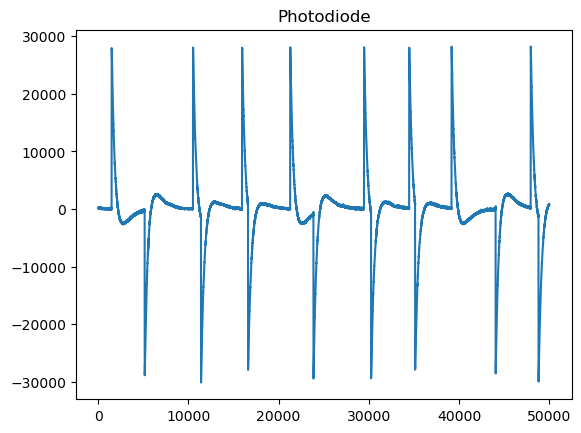

In [20]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('Photodiode')
plt.plot(mne_data._data[trig_ix, 800000:850000]) #hopefully 
plt.title("Photodiode")
plt.show()

In [30]:
len(mne_data._data[trig_ix])

1585280

## Add in electrode information


In [ ]:
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

In [ ]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in seeg_names}
trig_mapping_dict = {'Photodiode':'stim'} #'stim test1-ref' 'Stim TEST1-REF' stim stands for stimulus 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

In [ ]:
bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [ ]:
mne_data.info['bads'] = bads

In [ ]:
# Load the electrode localization data and add it in

csv_files = glob(f'{anat_dir}/*labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

# # identify the bundles for re-referencing:
# loc_data['bundle'] = np.nan
# loc_data['bundle'] = loc_data.apply(lambda x: ''.join(i for i in x.label if not i.isdigit()), axis=1)



In [ ]:
elec_locs

In [ ]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(MS007_data.ch_names, elec_locs.label)




In [ ]:
# Rename the mne data according to the localization data
new_name_dict = {x:y for (x,y) in zip(MS007_data.ch_names, new_mne_names)}
MS007_data.rename_channels(new_name_dict)

In [ ]:
unmatched_seeg

In [ ]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in MS007_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data.ch_names if i.startswith('l')]
# This is optional. I might want to look at scalp EEG at some point (lol) so might as well tag them here. 
eeg_names = [
 'fp1',
 'f7',
 't3',
 't5',
 'o1',
 'f3',
 'c3',
 'p3',
 'fp2',
 'f8',
 't4',
 't6',
 'o2',
 'f4',
 'c4',
 'p4',
 'fz',
 'cz',
 'pz']
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')
print(f'We have a total of {len(eeg_names)} EEG electrodes')
# MS007_data.set_channel_types()

In [ ]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
EEG_mapping_dict = {f'{x}':'eeg' for x in eeg_names}
trig_mapping_dict = {'dc1':'stim'}
# Drop random chans? 
drop_chans = list(set(MS007_data.ch_names)^set(eeg_names+left_seeg_names+right_seeg_names+['dc1']))
MS007_data.drop_channels(drop_chans)

In [ ]:
# Set channel types:
MS007_data.set_channel_types(sEEG_mapping_dict)
MS007_data.set_channel_types(EEG_mapping_dict)
MS007_data.set_channel_types(trig_mapping_dict)

In [97]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [98]:
new_name_dict

{'EEG LAM1-REF': 'lam1',
 'EEG LAM2-REF': 'lam2',
 'EEG LAM3-REF': 'lam3',
 'EEG LAM4-REF': 'lam4',
 'EEG LAM5-REF': 'lam5',
 'EEG LAM6-REF': 'lam6',
 'EEG LAM7-REF': 'lam7',
 'EEG LAM8-REF': 'lam8',
 'EEG LAM9-REF': 'lam9',
 'EEG LAM10-REF': 'lam10',
 'EEG LHH1-REF': 'lhh1',
 'EEG LHH2-REF': 'lhh2',
 'EEG LHH3-REF': 'lhh3',
 'EEG LHH4-REF': 'lhh4',
 'EEG LHH5-REF': 'lhh5',
 'EEG LHH6-REF': 'lhh6',
 'EEG LHH7-REF': 'lhh7',
 'EEG LHH8-REF': 'lhh8',
 'EEG LHH9-REF': 'lhh9',
 'EEG LHH10-REF': 'lhh10',
 'EEG LHB1-REF': 'lhb1',
 'EEG LHB2-REF': 'lhb2',
 'EEG LHB3-REF': 'lhb3',
 'EEG LHB4-REF': 'lhb4',
 'EEG LHB5-REF': 'lhb5',
 'EEG LHB6-REF': 'lhb6',
 'EEG LHB7-REF': 'lhb7',
 'EEG LHB8-REF': 'lhb8',
 'EEG LHB9-REF': 'lhb9',
 'EEG LHB10-REF': 'lhb10',
 'EEG LTP1-REF': 'ltp1',
 'EEG LTP2-REF': 'ltp2',
 'EEG LTP3-REF': 'ltp3',
 'EEG LTP4-REF': 'ltp4',
 'EEG LTP5-REF': 'ltp5',
 'EEG LTP6-REF': 'ltp6',
 'EEG LTP7-REF': 'ltp7',
 'EEG LTP8-REF': 'ltp8',
 'EEG LTP9-REF': 'ltp9',
 'EEG LTP10-REF': '

In [99]:
#rename mne data channels to remove unnecessary labels
mne_data.rename_channels(new_name_dict)

<RawEDF | DA8.edf, 82 x 1167360 (2280.0 s), ~730.4 MB, data loaded>

### Import Anat Recon Info - check all elecs are present in data + recon sheet


In [100]:
# Load the electrode localization data
da8_anat_file = glob(f'{anat_dir}/DA8_labels.csv')[0]
elec_locs = pd.read_csv(da8_anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination
0,LAM1,rHipp_L,-21.200002,12.400003,-12.389971,-21.513494,-6.166145,-20.461219,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala superior,NaN
1,LAM10,A21c_L,-64.800000,1.600004,-11.190942,-65.833070,-17.269594,-16.881921,Gray,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus B,NaN
2,LAM2,rHipp_L,-26.000002,11.200003,-11.990295,-26.428291,-7.416915,-19.952842,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala superior,NaN
3,LAM3,rHipp_L,-30.800002,10.400003,-11.590618,-31.316592,-8.269546,-19.507002,Gray,Left Amygdala,CA1 (Hippocampus),L Hippocampus,L Hipp,Left hippocampus pes,WM
4,LAM4,Unknown,-35.600002,9.200003,-11.590618,-36.120244,-9.633351,-19.392629,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,LTT5,A20r_L,-43.600001,14.800003,-23.181237,-43.323315,-8.034976,-33.571651,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left basal inferior temporal gyrus A,WM
66,LTT6,A20il_L,-47.600001,12.000003,-21.982207,-47.572561,-10.453217,-31.577884,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left lateral inferior temporal gyrus A,WM
67,LTT7,A20il_L,-51.200001,8.800003,-20.783178,-51.423078,-13.266819,-29.384452,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left lateral inferior temporal gyrus A,NaN
68,LTT8,A20il_L,-54.400000,4.800003,-19.184472,-54.886817,-16.673004,-26.370266,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left lateral inferior temporal gyrus B,WM


In [101]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['slave', 'ekgl', 'ekgr', 'ekg_lt_leg-r', 'ekgv1', 'ekgv5', 'air nasal-ref', '1', '2', 'sao2-ref', 'stim test1-ref', 'co2-ref']


In [102]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right' 'sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 70 left & 0 rightsEEG electrodes
We have a total of 70 sEEG electrodes


In [103]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['stim test1-ref']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | DA8.edf, 71 x 1167360 (2280.0 s), ~632.4 MB, data loaded>

In [104]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'stim test1-ref':'stim'} #'stim test1-ref' 'Stim TEST1-REF' stim stands for stimulus 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | DA8.edf, 71 x 1167360 (2280.0 s), ~632.4 MB, data loaded>

In [105]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | DA8.edf, 71 x 1167360 (2280.0 s), ~632.4 MB, data loaded>

### Notch filter line noise

In [106]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.7s finished


<RawEDF | DA8.edf, 71 x 1167360 (2280.0 s), ~632.4 MB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise

In [26]:
mne_data.save(f'{neural_dir}/DA8/photodiode.fif', picks='stim test1-ref', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [107]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

#resampling this patient is not necessary 
# resample_sr = 500
# mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

In [108]:
bads

['lip10',
 'lpo10',
 'lpo2',
 'lpo5',
 'lpo6',
 'lpo8',
 'ltp9',
 'ltt1',
 'ltt2',
 'ltt3',
 'ltt4']

In [109]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [111]:
probe_names

array(['lam', 'lhb', 'lhh', 'lip', 'lpo', 'ltp', 'ltt'], dtype='<U3')

In [112]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [113]:
probe_ch_counts

{'lam': 10, 'lhb': 10, 'lhh': 10, 'lip': 10, 'lpo': 10, 'ltp': 10, 'ltt': 10}

<IPython.core.display.Javascript object>


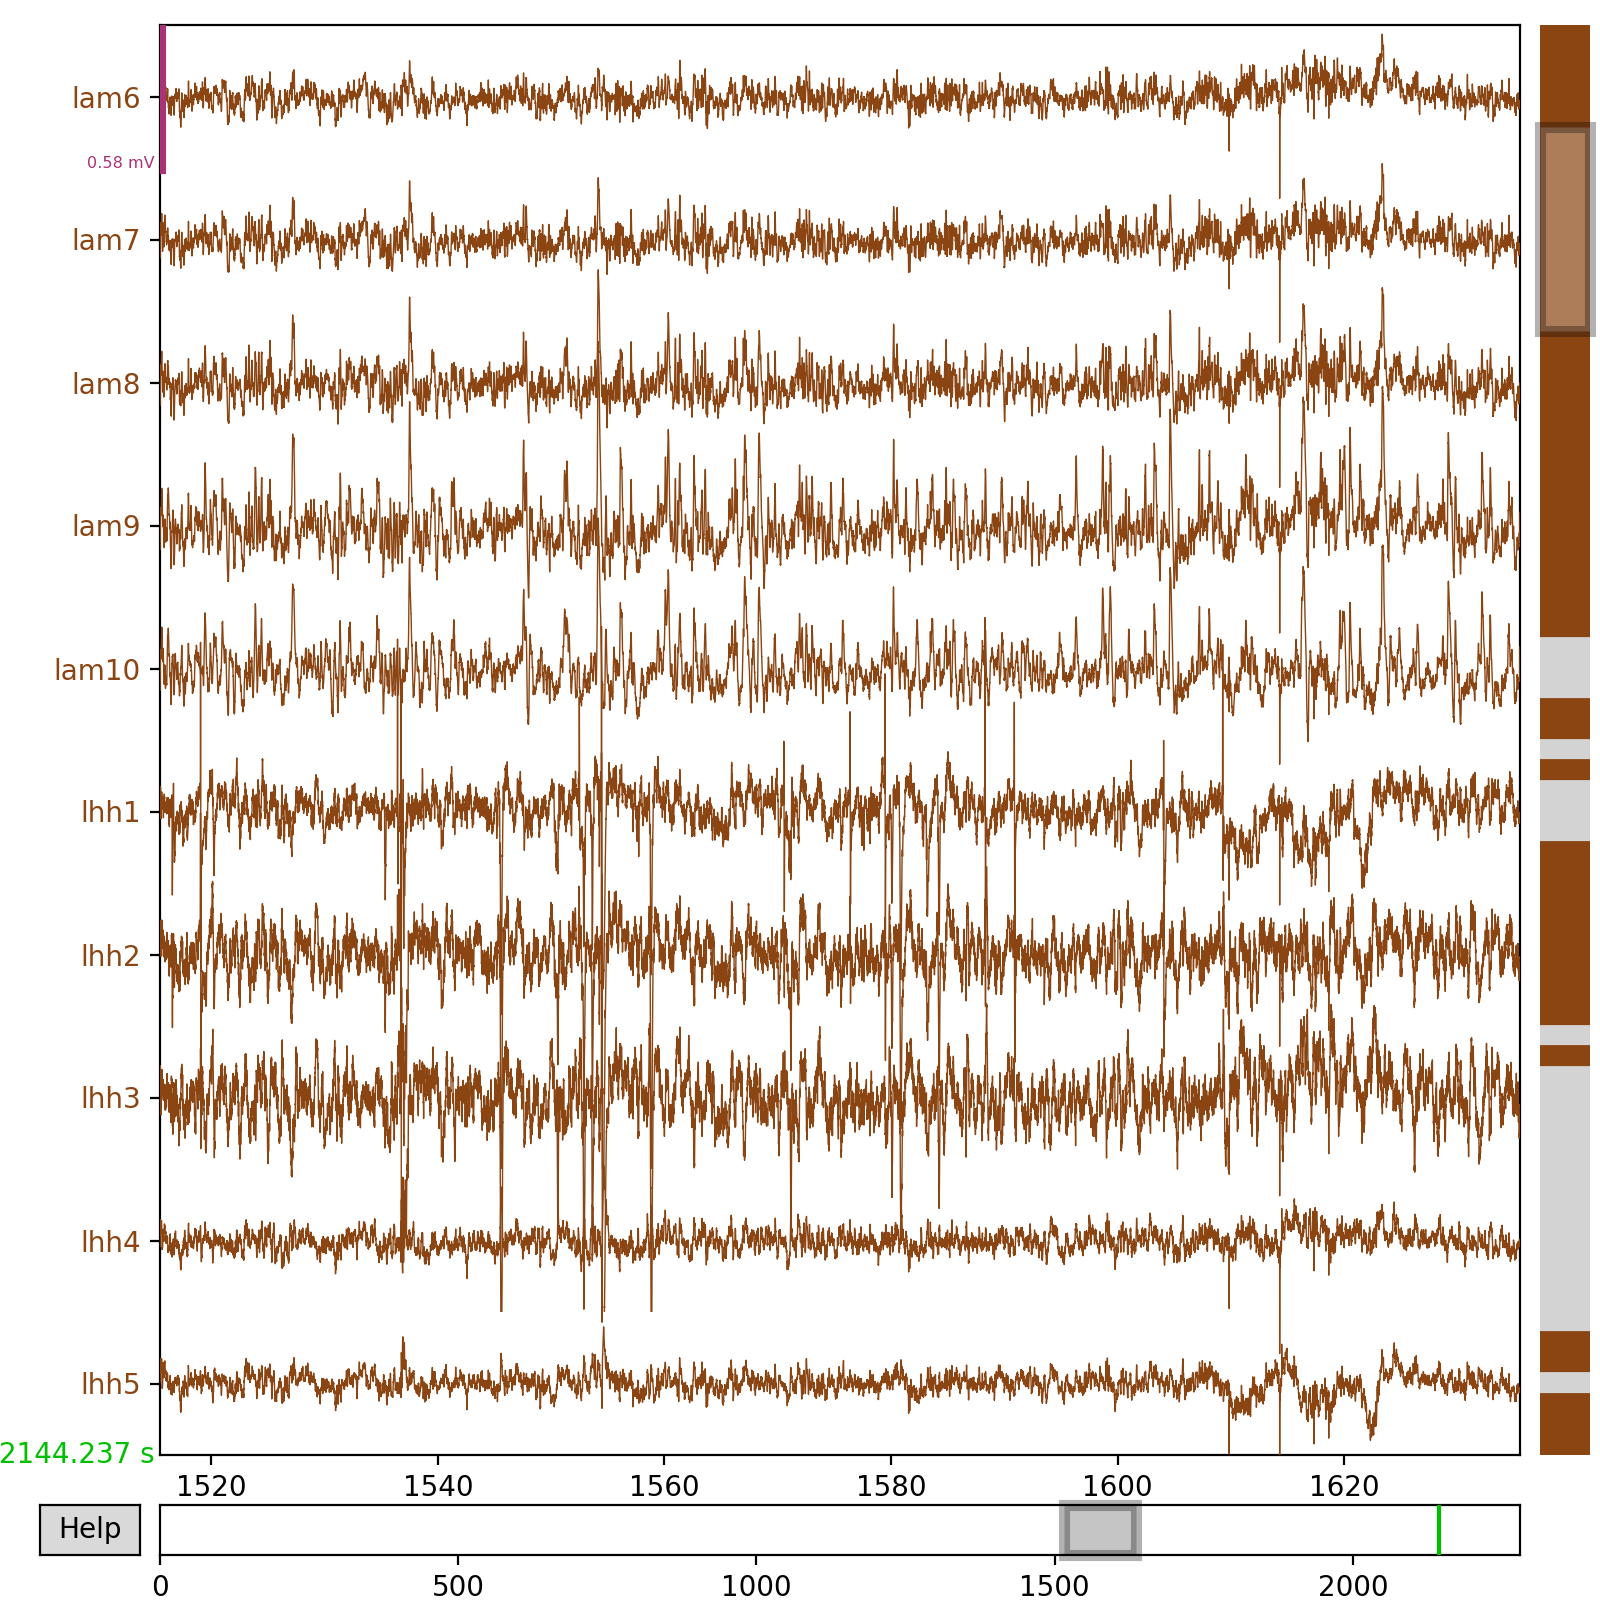

<IPython.core.display.Javascript object>


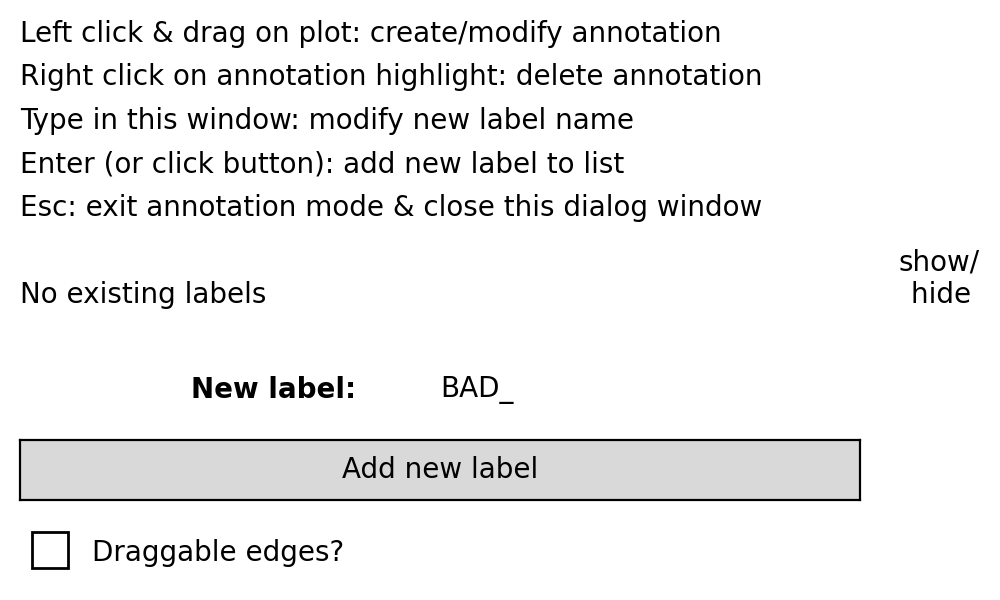

In [36]:
%matplotlib notebook #for some reason info isn't saving here, have to run notebook again to save? 
fig = mne_data.plot(start=0, duration=120, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

<IPython.core.display.Javascript object>


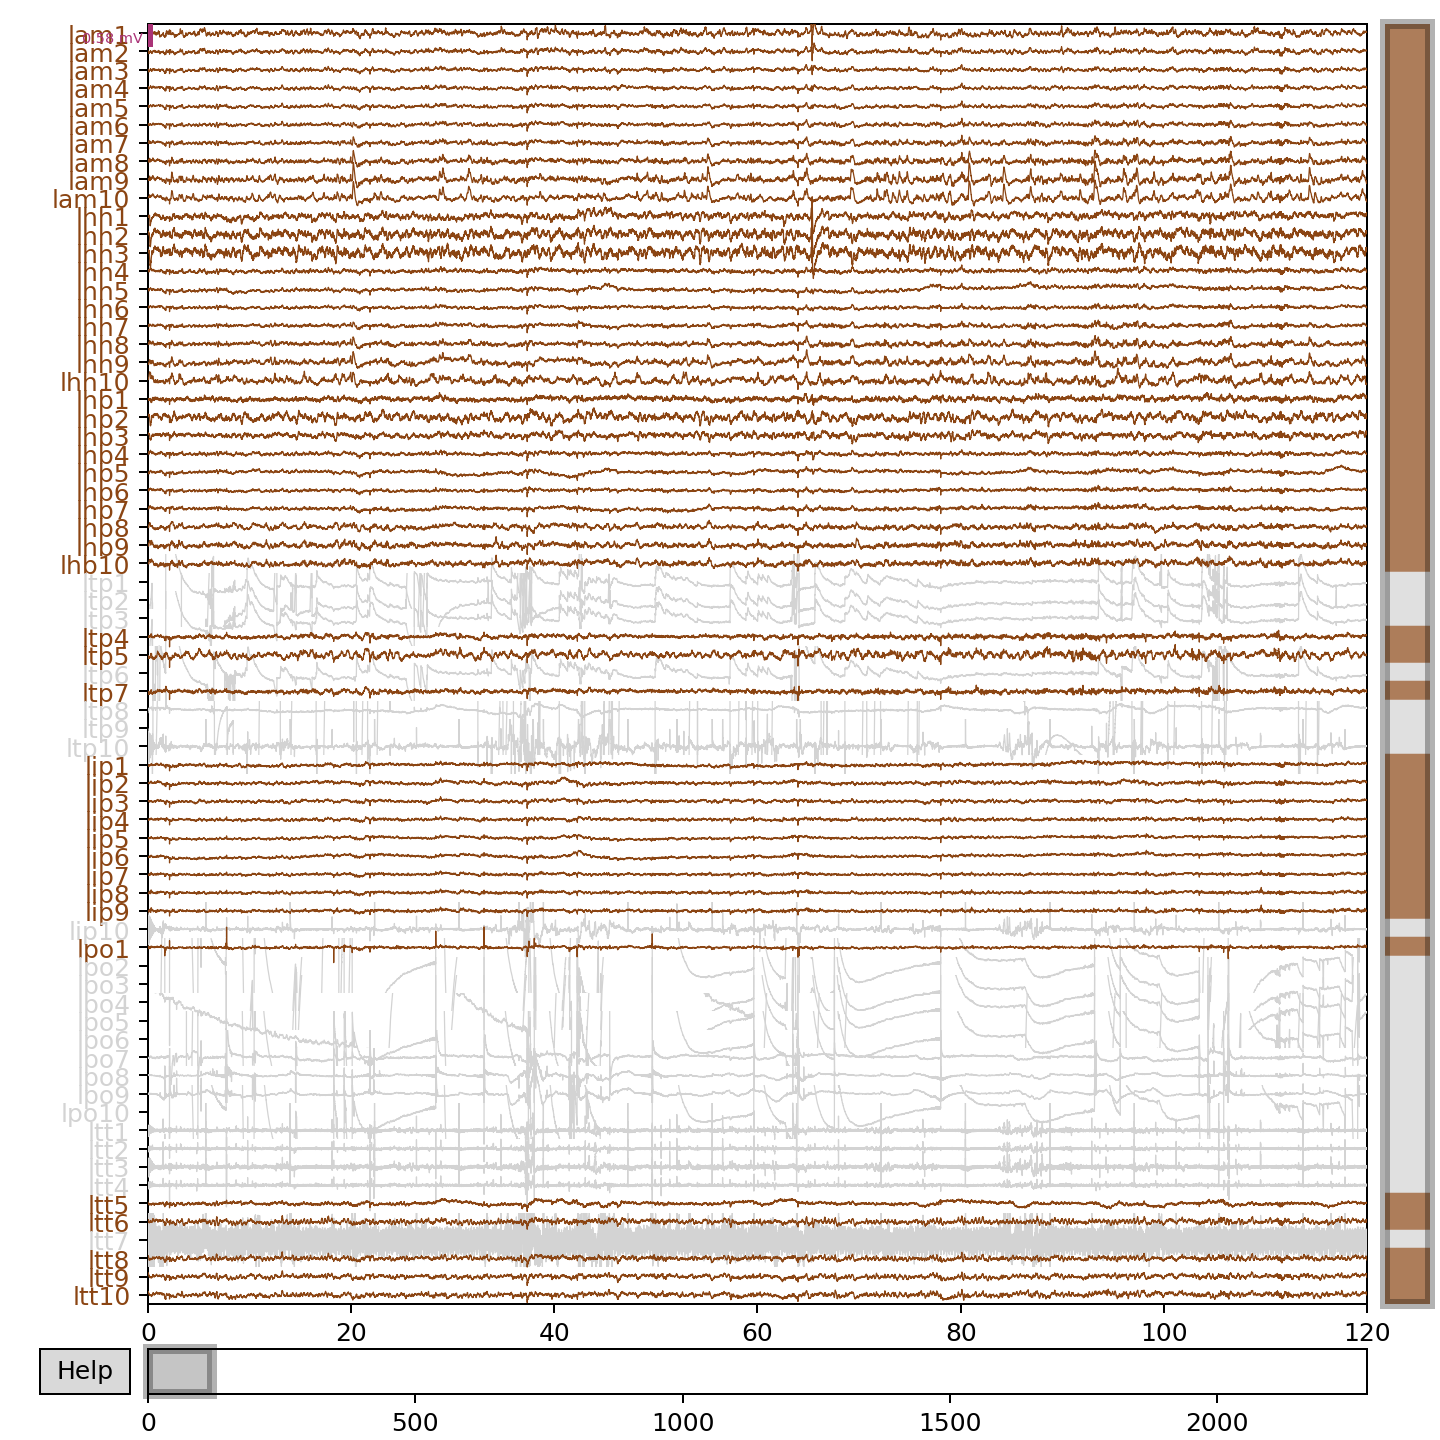

<IPython.core.display.Javascript object>


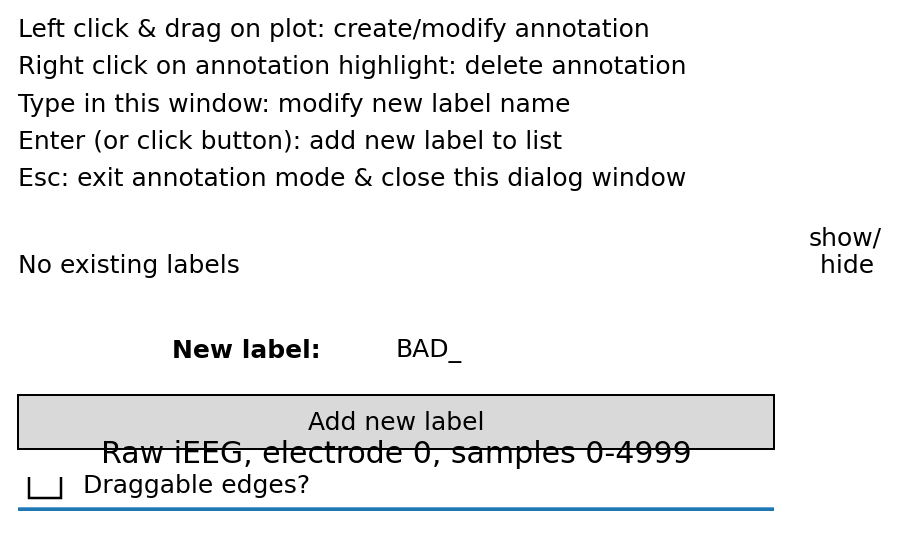

In [114]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=71, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [ ]:
##save info in SWB_electrode_info spreadsheet!
#['lip10', 'lpo10', 'lpo2', 'lpo5', 'lpo6', 'lpo8', 'ltp9', 'ltt1', 'ltt2', 'ltt3', 'ltt4', 'ltp1', 'ltp3', 'ltp6', 'ltp2', 'ltp10', 'lpo3', 'lpo4', 'lpo7', 'lpo9', 'ltt7', 'ltp8']

In [133]:
#set bad channel info 
da8_bad_ch = ['lip10', 'lpo10', 'lpo2', 'lpo5', 'lpo6', 'lpo8', 'ltp9', 'ltt1', 'ltt2', 'ltt3', 'ltt4', 'ltp1', 'ltp3', 'ltp6', 'ltp2', 'ltp10', 'lpo3', 'lpo4', 'lpo7', 'lpo9', 'ltt7', 'ltp8']

In [118]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = da8_bad_ch

In [120]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 22 items (lip10, lpo10, lpo2, lpo5, lpo6, lpo8, ltp9, ltt1, ...)
 ch_names: lam1, lam2, lam3, lam4, lam5, lam6, lam7, lam8, lam9, lam10, ...
 chs: 70 sEEG
 custom_ref_applied: False
 dig: 70 items (70 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2020-09-01 16:34:00 UTC
 nchan: 70
 projs: []
 sfreq: 512.0 Hz
>

In [121]:
mne_data.info['bads'] #more sanity checking

['lip10',
 'lpo10',
 'lpo2',
 'lpo5',
 'lpo6',
 'lpo8',
 'ltp9',
 'ltt1',
 'ltt2',
 'ltt3',
 'ltt4',
 'ltp1',
 'ltp3',
 'ltp6',
 'ltp2',
 'ltp10',
 'lpo3',
 'lpo4',
 'lpo7',
 'lpo9',
 'ltt7',
 'ltp8']

### Rereference data to wm electrodes

In [122]:
unmatched_seeg = [] #need this to run script, also need site = 'MSSM' because davis site specificity hasn't been implemented yet 

In [123]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=da8_anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [144]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
#da8_bad_ch = ['lip10', 'lpo10', 'lpo2', 'lpo5', 'lpo6', 'lpo8', 'ltp9', 'ltt1', 'ltt2', 'ltt3', 'ltt4', 'ltp1', 'ltp3', 'ltp6', 'ltp2', 'ltp10', 'lpo3', 'lpo4', 'lpo7', 'lpo9', 'ltt7', 'ltp8']
da8_bad_ch = da8_bad_ch + oob_channels
da8_bad_ch = list(np.unique(da8_bad_ch))
mne_data.info['bads'] = da8_bad_ch

In [158]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lip10',
 'lip9',
 'lpo10',
 'lpo2',
 'lpo3',
 'lpo4',
 'lpo5',
 'lpo6',
 'lpo7',
 'lpo8',
 'lpo9',
 'ltp1',
 'ltp10',
 'ltp2',
 'ltp3',
 'ltp6',
 'ltp8',
 'ltp9',
 'ltt1',
 'ltt2',
 'ltt3',
 'ltt4',
 'ltt7']

In [152]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [155]:
mne_data_reref

<RawEDF | DA8.edf, 57 x 1167360 (2280.0 s), ~507.7 MB, data loaded>

### Save cleaned continuous data

In [159]:
mne_data.save(f'{neural_dir}/DA8/lfp_data.fif')

In [160]:
mne_data_reref.save(f'{neural_dir}/DA8/wm_ref_ieeg.fif')